In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)  # Unlimited columns

# Data inspection
First, let's take a look at the dataset

In [2]:
sample_submission = pd.read_csv('original_data/sample_submission.csv')
test_features = pd.read_csv('original_data/test_features.csv')
train_features = pd.read_csv('original_data/train_features.csv')
train_labels = pd.read_csv('original_data/train_labels.csv')

In [3]:
sample_submission.shape, test_features.shape, train_features.shape, train_labels.shape

((14358, 2), (14358, 40), (59400, 40), (59400, 2))

In [4]:
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [5]:
train_features.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

# Data cleanup
I don't want to start out by using all the features available, as several of them are probably useless and require lots of cleanup.  So I'll create several cleanup functions that extract different subsets of the features.  I write them as functions so that I can easily apply them to the training and testing data equally.  This way, also, I don't need to commit to a particular set of features ahead of time.

In [6]:
def cleanup1(X):
    """
    Contains all the cleanup ideas that I encountered while working on
    this dataset.
    
    Parameters
    -----------
    X : Pandas.dataframe
        Full-featured dataset such as train_features or test_features
    
    Returns
    -----------
    X2 :  Pandas.dataframe
        Cleaned dataset
        
    """
    # Make a clean copy, to ensure we're not changing the original
    X2 = X.copy()
    
    
    # Regression on dates won't work.  Instead, I'll turn the 
    # date_recorded column into the number of years since 2000
    # (the earliest date in the training date is from 2000, and the
    # latest from 2013.)
    dates = pd.to_datetime(X2.date_recorded)
    year2000 = pd.to_datetime('2000-01-01')
    years = [i.days/365 for i in (dates - year2000)]
    X2.date_recorded = years
    
    # region_code and district_code are int64, but they should really be
    # treated as categories (and there's only 20-30 classes in each).
    # I'll cast them as strings instead.
    X2.region_code = X2.region_code.astype('str')
    X2.district_code = X2.district_code.astype('str')
    
    # recorded_by has only one value everywhere, and is therefore useless
    X2 = X2.drop(columns='recorded_by')
    
    # To prevent data conversion warnings, I'll turn all the numerical
    # features (except id) into float64.
    
    # Also, some columns contained bool values and NANs.  
    # (e.g., public_meeting, permit)
    # I replaced the NANs with strings, so I'll cast the whole series 
    # as strings to prevent future problems with data type heterogeneity.
    type_dict = {'amount_tsh':'float64',
                 'date_recorded':'float64',
                 'gps_height':'float64',
                 'longitude':'float64',
                 'latitude':'float64',
                 'num_private':'float64',
                 'population':'float64',
                 'construction_year':'float64',
                 'public_meeting':'str',
                 'permit':'str'}
    
    X2 = X2.astype(dtype = type_dict)
    

    
    
    return X2

In [25]:
def cleanup2(X):
    """
    Second batch of cleanup ideas, to happen after the first
    
    Parameters
    -----------
    X : Pandas.dataframe
        Full-featured dataset such as train_features or test_features
    
    Returns
    -----------
    X2 :  Pandas.dataframe
        Cleaned dataset
        
    """
    # Make a clean copy, to ensure we're not changing the original
    X2 = X.copy()
    
    # There are lots of hidden null values.  First, let's make sure they
    # are all visible as such
    
    nan_values_list = ['Not Known', 'Unknown', 'None', 'Not known', 'not known',
                  '-', 'unknown', 'Unknown Installer', '##', 'none']
    
    for alt_nan in nan_values_list:
        X2 = X2.replace(alt_nan, np.nan)
    
    ### Feature-by-feature cleanup
    # Lots of features have hidden garbage values that must be fixed,
    # or should have some of their values binned into something more 
    # useful.
    
    
    
    
    
    # Looking at all the features with missing values, it looks like those
    # features are all categorical variables where 'unknown' would be a
    # category we can work with.  I'll replace the NANs accordingly.
    X2 = X.fillna('unknown')
    
    
    
    return X2

In [27]:
df1 = cleanup1(train_features)

In [28]:
df2 = cleanup2(df1)

In [51]:
from sklearn.impute import MissingIndicator

def cleanup3(X):

    # Make a clean copy, to ensure we're not changing the original
    X2 = X.copy()
    num_cols = df2.select_dtypes('number')
    num_cols_list = num_cols.columns.tolist()
    
    # Longitudes of 0 are fake
    mean = num_cols.longitude.mean()
    num_cols.longitude = num_cols.longitude.replace(0, mean)

    
    # Drop the numerical columns from X2, replace them with the new ones
    X2 = X2.drop(columns=num_cols_list)
    X2 = pd.concat([num_cols, X2], sort=False)
    
    return X2

In [52]:
df3 = cleanup3(df2)

In [53]:
df3.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,population,construction_year,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,public_meeting,scheme_management,scheme_name,permit,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572.0,6000.0,11.205479,1390.0,34.938093,-9.856322,0.0,109.0,1999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8776.0,0.0,13.186301,1399.0,34.698766,-2.147466,0.0,280.0,2010.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,34310.0,25.0,13.161644,686.0,37.460664,-3.821329,0.0,250.0,2009.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67743.0,0.0,13.084932,263.0,38.486161,-11.155298,0.0,58.0,1986.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19728.0,0.0,11.536986,0.0,31.130847,-1.825359,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
df3.shape

(118800, 39)

In [14]:
from sklearn.impute import MissingIndicator





# indicator = MissingIndicator()
# garbage = indicator.fit_transform(num_cols)
# garbage

In [15]:
num_cols.head()

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,population,construction_year
0,69572,6000.0,11.205479,1390.0,34.938093,-9.856322,0.0,109.0,1999.0
1,8776,0.0,13.186301,1399.0,34.698766,-2.147466,0.0,280.0,2010.0
2,34310,25.0,13.161644,686.0,37.460664,-3.821329,0.0,250.0,2009.0
3,67743,0.0,13.084932,263.0,38.486161,-11.155298,0.0,58.0,1986.0
4,19728,0.0,11.536986,0.0,31.130847,-1.825359,0.0,0.0,0.0


In [21]:
name = 'gps_height'

df2[name].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

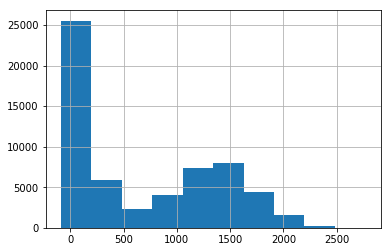

In [22]:
df2[name].hist()

In [23]:
df2[name].value_counts()

 0.0       20438
-15.0         60
-16.0         55
-13.0         55
 1290.0       52
-20.0         52
 303.0        51
-14.0         51
-18.0         49
-19.0         47
 1269.0       46
 1295.0       46
-23.0         45
 1304.0       45
 280.0        44
-17.0         44
-8.0          44
 1538.0       44
 1286.0       44
 1332.0       43
 320.0        43
 1359.0       42
 1319.0       42
 1293.0       42
-27.0         42
 1264.0       42
 1303.0       42
 1288.0       42
 1401.0       42
 1317.0       42
           ...  
 2536.0        1
 2015.0        1
 591.0         1
 2576.0        1
 2250.0        1
 2243.0        1
 2345.0        1
 2302.0        1
 2402.0        1
 2366.0        1
 2312.0        1
 2254.0        1
 649.0         1
 2627.0        1
 2285.0        1
 2209.0        1
 2424.0        1
 2207.0        1
 622.0         1
 2264.0        1
 2257.0        1
 2535.0        1
 2236.0        1
-57.0          1
 2321.0        1
 2201.0        1
 2539.0        1
-53.0         

In [24]:
df3[name].describe()

NameError: name 'df3' is not defined

In [ ]:
df3[name].hist()

In [ ]:
df3[name].value_counts()